In [104]:
import numpy as np
import pandas as pd

import os, sys
import random

try:
    os.chdir('CrowdInference')
    sys.path.append(os.getcwd())
except:
    pass

import crowd_inference.methods.dawid_skene as ds
import crowd_inference.methods.majority_vote as mv
import crowd_inference.methods.raykar as r
import crowd_inference.methods.raykar_plus_ds as rds
import crowd_inference.methods.classifier as cls
import benchmark as bm

from crowd_inference.truth_inference import NoFeaturesInference, TruthInference, WithFeaturesInference
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt
from collections import defaultdict
import tests.data_provider as data
from tqdm.auto import tqdm
from typing import Iterable, Dict, List, Optional, Tuple

import seaborn as sns
sns.set()

from importlib import reload

def reload_all():
    reload(ds)
    reload(r)
    reload(rds)
    reload(cls)
    reload(bm)

reload(data)

<module 'tests.data_provider' from '/Users/andrey/Documents/5Course/CrowdInference/tests/data_provider.py'>

In [2]:
sentiment_data = data.SentimentDataProvider('./resources/datasets/sentiment_polarity/mturk_answers.csv',
                                       './resources/datasets/sentiment_polarity/polarity_gold_lsa_topics.csv')

In [72]:
reload_all()

flip_probs = [0.2, 0.2, 0.3, 0.5, 0.6]
# flip_probs = [0.3]
ionosphere_data = data.IonosphereProvider('./resources/datasets/ionosphere/ionosphere.pickle', 
                                     resample=True,
                                     path='./resources/datasets/ionosphere/ionosphere.csv',
                                     flip_probs=flip_probs,
                                     annotate_prob=0.7)
mushrooms_data = data.MushroomsDataProvider(resample=True, flip_probs=flip_probs, annotate_prob=0.7)
music_data = data.MusicDataProvider()
toloka_data = data.TolokaDataProvider()

def features2np(provider: data.DataProvider) -> Tuple[np.ndarray, np.ndarray]:
    features = provider.features()
    n_features = len(features[list(features.keys())[0]])
    n_tasks = len(features)
    X = np.zeros((n_tasks, n_features))
    y = []
    for i, estimation in enumerate(provider.gold()):
        X[i] = features[estimation.task]
        y.append(estimation.value)
    
    return X, np.array(y)
        

def get_classifier_accuracy(inference: WithFeaturesInference, data_provider: data.DataProvider):
    X, y = features2np(data_provider)
    classification = inference.apply_classifier(X)
    accuracy = accuracy_score(y, classification)
    print(f'Classifier train accuracy is {accuracy}')
    
    correct_test = 0
    if isinstance(data_provider, data.MusicDataProvider) \
       or isinstance(data_provider, data.SentimentDataProvider) or isinstance(data_provider, data.MushroomsDataProvider):
        X, y = data_provider.test()
        classification = inference.apply_classifier(X)
        test_accuracy = accuracy_score(y, classification)
        print(f'Classifier test accuracy is {test_accuracy}')


def _get_accuracy(provider: data.DataProvider, inference: TruthInference, max_iter: int, confidence_estimator, lr: float):
    correct = []
    incorrect = []
    accepted = 0
    all_points = 0
    estimates = {}

    if isinstance(inference, ds.DawidSkene):
        inference.fit(provider.labels(), max_iter=max_iter)
    elif isinstance(inference, r.Raykar):
        inference.fit(provider.labels(), provider.features(), max_iter=max_iter, lr=lr)
        get_classifier_accuracy(inference, provider)
    else:
        inference.fit(provider.labels(), provider.features(), max_iter=max_iter, confidence_estimator=confidence_estimator, lr=lr)
        get_classifier_accuracy(inference, provider)    

    for estimate in inference.estimate():
        estimates[estimate.task] = estimate.value
    for point in provider.gold():
        if point.task in estimates:
            estimate = estimates[point.task]
            all_points += 1
            if point.value == estimate:
                accepted += 1
                correct.append(point)
            else:
                incorrect.append(point)

    accuracy = accepted / all_points
    print(f'Label accuracy is {accuracy}')

    return accuracy, {e.task for e in correct}, {e.task for e in incorrect}


def compare_methods(provider, max_iter=15, confidence_estimator=None, lr=0.1):
    results = []
    points_results = []
    methods = [ds.DawidSkene(),
               r.Raykar(), rds.RaykarPlusDs(), 
#                rds.RaykarPlusDs(binary=True)
              ]
    points = []
    
    for method in methods:
        accuracy, correct, incorrect = _get_accuracy(provider, method, max_iter, confidence_estimator, lr)
        results.append((method.__str__(), accuracy))
        plt.plot(method.logit_)
        points_results.append((correct, incorrect))
        print('-' * 50)
        task, mu, classifier, likelihood_rds, conf_mx, index, grads = [], [], [], [], [], [], []
        for k, v in method.predictions_.items():
            task.append(k)
            mu.append(np.round(v[1], 3))
            if isinstance(method, WithFeaturesInference):
                classifier.append(np.round(v[2], 3))
                grads.append(np.round(v[3], 5))
                conf_mx.append(np.round(v[4], 3))
            if isinstance(method, rds.RaykarPlusDs):
#                 method_rds.append("R" if v[3] else "DS")
                likelihood_rds.append(np.round(v[6], 3))
                index.append(v[7])
        
        columns = {'task': task, 'mu': mu}
        if len(classifier):
            columns['classifier'] = classifier
            columns['grad'] = grads
            columns['conf_mx'] = conf_mx
        if len(likelihood_rds):
#             columns['method_rds'] = method_rds
            columns['likelihood_rds'] = likelihood_rds
            columns['index'] = index

        points.append(pd.DataFrame(columns))
        
    print(len(points))
    points_aggregated = points[1].merge(points[2], on='task', suffixes=('_r', '_rds'))
    points_aggregated = points_aggregated.merge(points[0], on='task')
    points_aggregated.rename(columns={'mu': 'mu_ds'}, inplace=True)
    
    print(results)
        
    plt.legend(list(map(str, methods)))

    # Get points advantages
    advantages = []
    for i in range(len(methods)):
        advantages.append([])
        for j in range(len(methods)):
            advantages[i].append(points_results[i][0] - points_results[j][0])
    
    return methods, points_aggregated, advantages

def print_conf(methods):
    assessors = []
    for m in methods:
        print(m)
        print(m.conf_mx[:, 0, 0])
        print(m.conf_mx[:, 1, 1])
        
def shuffle_features(data):
    features_list = []
    for k in data._features.keys():
        features_list.append(data._features[k])
    random.shuffle(features_list)
    for k, f in zip(data._features.keys(), features_list):
        data._features[k] = f
        
def plots_for_point(points, data, methods, k):
    plt.figure(figsize=(10, 6))

    task = points[points.index == k].task.values[0]
    for est in data.labels():
        if est.task == task:
            print(est)

    plt.plot(methods[2].mus[:, k, 0])
    plt.plot(methods[1].mus[:, k, 0])
    plt.plot(methods[0].mus[:, k, 0])

    plt.plot(methods[2].cls[:, k, 0])
    plt.plot(methods[1].cls[:, k, 0])

    plt.plot(methods[2].weights[:, k])

    plt.legend(['RDS', 'R', 'DS', 'Classifier RDS', 'Classifier R',
                'Raykar weight'])
    
def build_grad_hist(data, methods, points, name, n_bucket = 100):
    gold_dict = {e.task: e.value for e in data.gold()}
    
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.subplots(nrows=2, ncols=1)
    print(f'Number of data points: {len(points)}')
    
    results = []
    buckets = []
    confidences = []
    
    wrong, correct = [], []
    
    for method in [1]:
        result = []
        buckets.append([])
        for _, p in points.iterrows():
            flipped = False
#             if  method == 2:
#                 clazz = np.argmax(p.classifier_rds)
#                 grad = np.abs(p.grad_rds)
#             elif method == 1:
            clazz = np.argmax(p.classifier_r)
            grad = np.abs(p.grad_r)
            flipped = np.argmax(p.mu_r) != np.argmax(p.conf_mx_r)
            
            if np.argmax(p.classifier_r) == methods[method].value_to_id[gold_dict[p.task]]:
                if flipped:
                    correct.append(p)
                result.append([grad, True, flipped, False])
#                 raise ValueError(p)
            else:
                if flipped:
                    wrong.append(p)
                result.append([grad, False, False, flipped])

        result = np.array(sorted(result))

        n = int(np.ceil(len(points) / n_bucket))
        xs = []
        widths = []
        heights_accuracy = []
        heights_flipped_good, heights_flipped_bad = [], []
        for i in range(n):
            cur_points = result[n_bucket * i: min(n_bucket * (i + 1), len(points))]
            xs.append((cur_points[0, 0] + cur_points[-1, 0]) * 0.5)
            widths.append((cur_points[-1, 0] - cur_points[0, 0]))
            heights_accuracy.append(cur_points[:, 1].sum() / len(cur_points))
            heights_flipped_good.append(cur_points[:, 2].sum() / len(cur_points))
            heights_flipped_bad.append(cur_points[:, 3].sum() / len(cur_points))

            buckets[-1].append(cur_points[:, 0])
        
        xs = np.array(xs)
        widths = np.array(widths)
        
        ax[method - 1].bar(xs, height=heights_accuracy, width=widths)
#         print(heights_flipped)
        
        flipped_widths = widths / 2
        ax[1].bar(xs - flipped_widths / 2, height=heights_flipped_good, width=flipped_widths)
        ax[1].bar(xs + flipped_widths / 2, height=heights_flipped_bad, width=flipped_widths)


        ax[method - 1].set_title(name + " Точность работы классификатора в зависимости от градиента")
        ax[method].set_title(name + " Классификатор изменил самый вероятный класс")
        ax[method].legend(['Изменил на правильный', 'Изменил на неправильный'])
         
        confidences.append(heights_accuracy)
        
    return buckets, confidences, wrong, correct

def get_confidence(buckets, confidences):
    def get_confidence_binded(x):
        x = np.abs(x)
        for i in range(len(confidences) - 1):
#             print(buckets[i])
            if x < buckets[i][-1]:
                return confidences[i]
        return confidences[-1]
    return get_confidence_binded

1201
3916
4208


[ -46.08288234 -110.91031345  -44.31238965 -141.37188809 -130.02207616]
Iter 00, logit: -33.418706
[ -48.63709058 -132.06325373  -46.33876939 -181.02444181 -206.14438583]
[ -48.6171986  -132.15882373  -46.74658679 -180.22365917 -207.7306974 ]
[ -48.44829322 -132.2322169   -46.89657868 -180.2199292  -207.73070265]
[ -48.27665663 -132.29132895  -47.04053279 -180.2199292  -207.73070255]
[ -48.06721569 -132.29409197  -47.24112863 -180.2199292  -207.73070246]
[ -47.71761726 -132.29410265  -47.5930871  -180.2199292  -207.73070245]
[ -46.86556906 -132.2941027   -48.53982104 -180.2199292  -207.73070246]
[ -43.8621189  -132.29410273  -53.52565186 -180.2199292  -207.73070246]
[ -41.73455731 -132.29410284  -62.10392065 -180.2199292  -207.73070249]
[ -41.69884862 -132.29410294  -62.14967839 -180.2199292  -207.73070251]
Iter 10, logit: -28.216356
[ -41.686957   -132.29410294  -62.16271665 -180.2199292  -207.73070251]
[ -41.68220501 -132.29410294  -62.16795368 -180.2199292  -207.73070251]
[ -41.6801

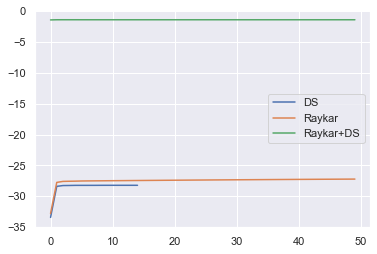

In [41]:
reload_all()
# np.seterr(all='raise')
toloka_methods, toloka_points, advantages_matrix = compare_methods(toloka_data, max_iter=50, lr=100)

Number of data points: 991


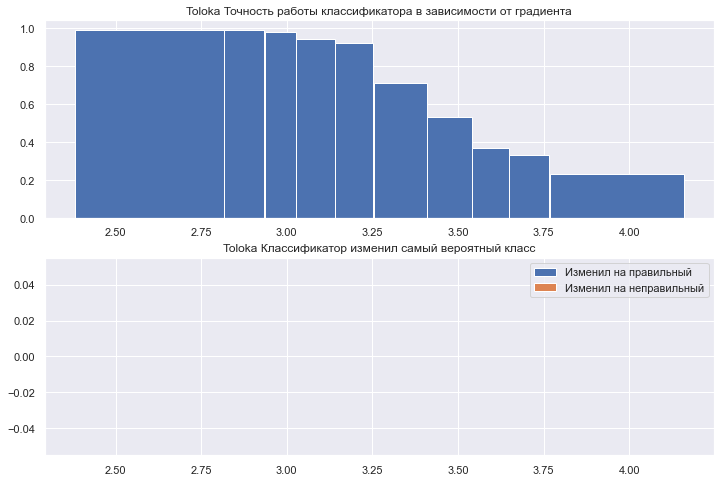

In [39]:
buckets, confidences = build_grad_hist(toloka_data, toloka_methods, toloka_points, 'Toloka', 100)
condidence_toloka = get_confidence(buckets[0], confidences[0])

In [ ]:
reload_all()

toloka_methods, toloka_points, advantages_matrix = compare_methods(toloka_data, max_iter=50, lr=100,
                                                                        confidence_estimator=condidence_toloka)

In [40]:
# toloka_points[toloka_points.task.isin(advantages_matrix[2][0])]
toloka_points

,task,mu_r,classifier_r,grad_r,conf_mx_r,mu_rds,classifier_rds,grad_rds,conf_mx_rds,likelihood_rds,index,mu_ds
0,t0,"[0.0, 1.0, 0.0, 0.0, 0.0]","[0.216, 0.253, 0.165, 0.171, 0.195]",3.43214,"[-inf, -21.13, -inf, -inf, -inf]","[0.0, 1.0, 0.0, 0.0, 0.0]","[0.215, 0.253, 0.166, 0.172, 0.194]",3.43535,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0]",0,"[0.0, 1.0, 0.0, 0.0, 0.0]"
1,t1,"[0.0, 0.0, 1.0, 0.0, 0.0]","[0.185, 0.179, 0.305, 0.155, 0.176]",3.22330,"[-inf, -inf, -5.446, -inf, -inf]","[0.0, 0.0, 1.0, 0.0, 0.0]","[0.184, 0.179, 0.307, 0.154, 0.177]",3.21523,"[0.0, 0.0, 0.004, 0.0, 0.0]","[0.0, 1.0]",1,"[0.0, 0.0, 1.0, 0.0, 0.0]"
2,t10,"[0.0, 0.0, 1.0, 0.0, 0.0]","[0.124, 0.124, 0.459, 0.151, 0.142]",2.54126,"[-inf, -inf, -3.475, -inf, -inf]","[0.0, 0.0, 1.0, 0.0, 0.0]","[0.123, 0.125, 0.459, 0.151, 0.142]",2.54123,"[0.0, 0.0, 0.029, 0.0, 0.0]","[0.0, 1.0]",2,"[0.0, 0.0, 1.0, 0.0, 0.0]"
3,t100,"[0.0, 0.0, 1.0, 0.0, 0.0]","[0.228, 0.199, 0.179, 0.193, 0.201]",3.75882,"[-inf, -inf, -44.979, -inf, -inf]","[0.0, 0.0, 1.0, 0.0, 0.0]","[0.228, 0.197, 0.18, 0.191, 0.203]",3.75296,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0]",3,"[0.0, 0.0, 1.0, 0.0, 0.0]"
4,t1000,"[1.0, 0.0, 0.0, 0.0, 0.0]","[0.184, 0.171, 0.272, 0.169, 0.203]",3.77568,"[-32.948, -inf, -inf, -inf, -inf]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0.186, 0.172, 0.269, 0.168, 0.205]",3.76889,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0]",4,"[1.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
986,t995,"[1.0, 0.0, 0.0, 0.0, 0.0]","[0.228, 0.236, 0.162, 0.161, 0.213]",3.63793,"[-35.142, -inf, -inf, -inf, -inf]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0.228, 0.235, 0.164, 0.16, 0.214]",3.64082,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0]",986,"[1.0, 0.0, 0.0, 0.0, 0.0]"
987,t996,"[0.0, 1.0, 0.0, 0.0, 0.0]","[0.172, 0.234, 0.258, 0.151, 0.185]",3.55126,"[-inf, -21.466, -inf, -inf, -inf]","[0.0, 1.0, 0.0, 0.0, 0.0]","[0.172, 0.234, 0.258, 0.152, 0.184]",3.55422,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0]",987,"[0.0, 1.0, 0.0, 0.0, 0.0]"
988,t997,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.234, 0.158, 0.256, 0.194, 0.158]",3.84535,"[-inf, -inf, -inf, -inf, -20.846]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.235, 0.155, 0.258, 0.195, 0.157]",3.85016,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0]",988,"[0.0, 0.0, 0.0, 0.0, 1.0]"
989,t998,"[1.0, 0.0, 0.0, 0.0, 0.0]","[0.172, 0.154, 0.292, 0.195, 0.188]",3.82230,"[-39.621, -inf, -inf, -inf, -inf]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0.174, 0.154, 0.289, 0.198, 0.185]",3.81177,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0]",989,"[1.0, 0.0, 0.0, 0.0, 0.0]"


Annotation(annotator='w200', task='t998', value='3')
Annotation(annotator='w448', task='t998', value='3')
Annotation(annotator='w485', task='t998', value='1')
Annotation(annotator='w621', task='t998', value='1')
Annotation(annotator='w761', task='t998', value='3')
Annotation(annotator='w417', task='t998', value='3')
Annotation(annotator='w827', task='t998', value='3')
Annotation(annotator='w184', task='t998', value='3')
Annotation(annotator='w178', task='t998', value='1')
Annotation(annotator='w236', task='t998', value='3')
Annotation(annotator='w196', task='t998', value='3')
Annotation(annotator='w114', task='t998', value='3')
Annotation(annotator='w824', task='t998', value='3')
Annotation(annotator='w450', task='t998', value='1')
Annotation(annotator='w692', task='t998', value='1')
Annotation(annotator='w478', task='t998', value='3')
Annotation(annotator='w452', task='t998', value='3')
Annotation(annotator='w70', task='t998', value='3')
Annotation(annotator='w152', task='t998', value

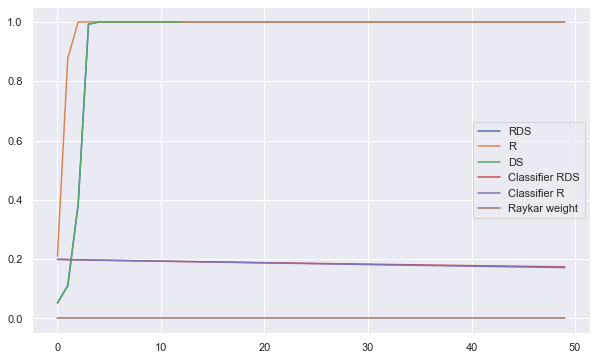

In [20]:
plots_for_point(toloka_points, toloka_data, toloka_methods, 989)

[-1.99548556 -2.5985527 ]
Iter 00, logit: -2.859080
[-2.10426622 -2.51118496]
[-2.20431231 -2.48587393]
[-2.28283117 -2.4947265 ]
[-2.33254613 -2.5177644 ]
[-2.35655454 -2.54252633]
[-2.36367132 -2.56373651]
[-2.36213139 -2.58028035]
[-2.35724042 -2.59262823]
[-2.35174678 -2.60161638]
[-2.3468277 -2.6080356]
Iter 10, logit: -2.706325
[-2.34285153 -2.61253292]
[-2.339823  -2.6156103]
[-2.33761016 -2.61764759]
[-2.33604944 -2.61892809]
[-2.33498875 -2.61966113]
[-2.33430164 -2.62000033]
[-2.3338888  -2.62005783]
[-2.33367474 -2.61991525]
[-2.33360324 -2.6196318 ]
[-2.33363297 -2.61925038]
Iter 20, logit: -2.704224
[-2.33373384 -2.61880205]
[-2.33388404 -2.61830925]
[-2.33406783 -2.61778824]
[-2.33427391 -2.61725074]
[-2.33449418 -2.61670523]
[-2.33472282 -2.61615783]
[-2.3349557  -2.61561293]
[-2.33518986 -2.6150737 ]
[-2.33542322 -2.61454236]
[-2.3356543  -2.61402051]
Iter 30, logit: -2.703750
[-2.33588207 -2.61350925]
[-2.33610583 -2.61300929]
[-2.33632509 -2.61252111]
[-2.33653954 -2.

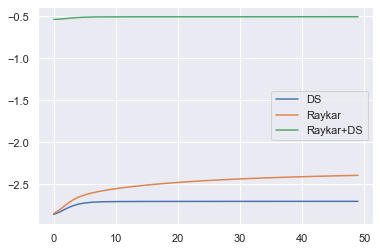

In [49]:
reload_all()

mushrooms_methods, mushroom_points, advantages_matrix = compare_methods(mushrooms_data, max_iter=50)
print_conf(mushrooms_methods)

In [ ]:
# mushroom_points[mushroom_points.task.isin(advantages_matrix[1][2])][:20]

Number of data points: 6499


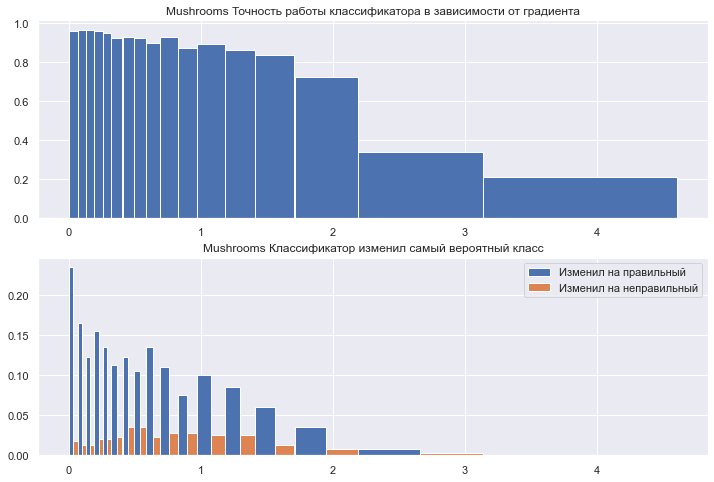

In [73]:
buckets, confidences, wrong, correct = build_grad_hist(mushrooms_data, mushrooms_methods, mushroom_points, 'Mushrooms', 400)
condidence_mushrooms = get_confidence(buckets[0], confidences[0])

In [108]:
condidence_mushrooms(0.3)

0.95

In [ ]:
reload_all()

mushrooms_methods, mushroom_points, advantages_matrix = compare_methods(mushrooms_data, max_iter=50, 
                                                                        confidence_estimator=condidence_mushrooms)
print_conf(mushrooms_methods)

In [ ]:
# mushroom_points[mushroom_points.task.isin(advantages_matrix[2][1])]
mushroom_points[mushroom_points.grad_rds > 3]

In [ ]:
plots_for_point(mushroom_points, mushrooms_data, mushrooms_methods, 33)

In [ ]:
reload_all()

ionosphere_methods, ionosphere_points, advantages_matrix = compare_methods(ionosphere_data, max_iter=150)
print_conf(ionosphere_methods)

In [ ]:
ionosphere_points[ionosphere_points.task.isin(advantages_matrix[1][2])]

In [ ]:
build_grad_hist(ionosphere_data, ionosphere_methods, ionosphere_points, 'Ionosphere', 30)

In [ ]:
plots_for_point(ionosphere_points, ionosphere_data, ionosphere_methods, 13)

Iter 00, logit: -3.019628
Iter 10, logit: -2.783967
---------------
Label accuracy is 0.915383076615323
--------------------------------------------------
Data has 600 features
Iter 00, logit: -2.990713
Iter 10, logit: -2.647791
(4999, 600)
Classifier train accuracy is 0.7091418283656732
(5428, 600)
Classifier test accuracy is 0.6352247605011054
Label accuracy is 0.9181836367273455
--------------------------------------------------
Data has 600 features
Iter 00, logit: -0.538373
Average Raykar weight is 0.0
Iter 10, logit: -0.450310
Average Raykar weight is 0.0
Average Raykar weight is 0.0
Classifier train accuracy is 0.7085417083416683
Classifier test accuracy is 0.6381724392041267
Label accuracy is 0.9147829565913183
--------------------------------------------------
3
[('DS', 0.915383076615323), ('Raykar', 0.9181836367273455), ('Raykar+DS', 0.9147829565913183)]


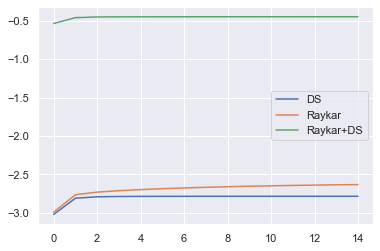

In [98]:
reload(ds), reload(r), reload(rds)

sentiment_methods, sentiment_points, advantages_matrix = compare_methods(sentiment_data, max_iter=15)

Number of data points: 4999


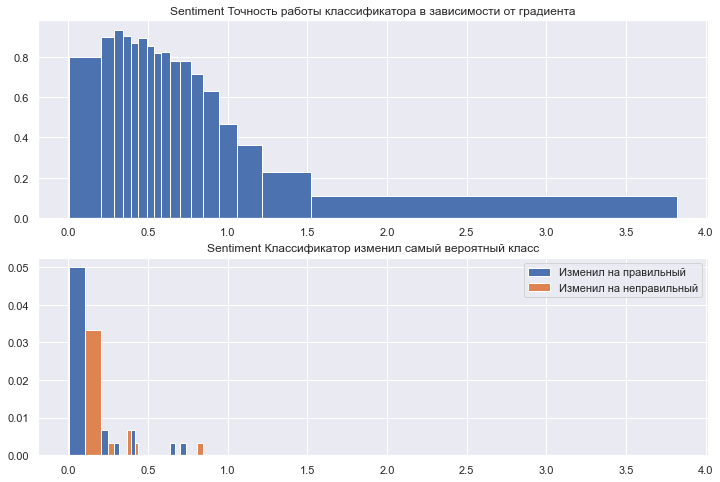

In [85]:
buckets, confidences, wrong, correct = build_grad_hist(sentiment_data, sentiment_methods, sentiment_points, 'Sentiment', 300)
condidence_sentiment = get_confidence(buckets[0], confidences[0])

/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


22 15


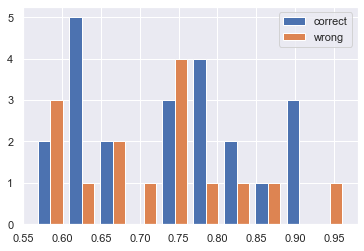

In [90]:
plot_flips(correct, wrong, 'classifier_r')

Iter 00, logit: -3.019628
Iter 10, logit: -2.783967
---------------
Label accuracy is 0.915383076615323
--------------------------------------------------
Data has 600 features
Iter 00, logit: -2.990713


KeyboardInterrupt: 

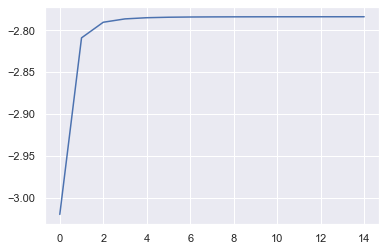

In [97]:
sentiment_methods, sentiment_points, advantages_matrix = compare_methods(sentiment_data, max_iter=15, 
                                                                         confidence_estimator=condidence_sentiment)

In [101]:
advantages_matrix[1][0]
# sentiment_points
# plots_for_point(sentiment_points, sentiment_data, sentiment_methods, 1)

{684,
 1231,
 1772,
 1847,
 1888,
 1901,
 2512,
 2787,
 2824,
 2973,
 3493,
 3586,
 3603,
 4680,
 4899,
 4908,
 4935,
 4987,
 5063,
 5205,
 5313,
 5458,
 5463,
 5651,
 6387,
 6576,
 6971,
 7146,
 7173,
 7279,
 8455,
 9660}

In [ ]:
plots_for_point(sentiment_points, sentiment_data, sentiment_methods, 239)

0.914382876575315
0.5


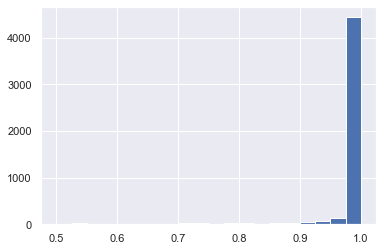

In [47]:
def build_conf_hist(points, name):
    max_confidence = np.array(list(map(lambda x: x.max(), points[name].values)))
    plt.hist(max_confidence, bins=20)
    print((max_confidence > 0.95).mean())
    print(max_confidence.min())
build_conf_hist(sentiment_points, 'mu_ds')

0.9199839967993598
0.502


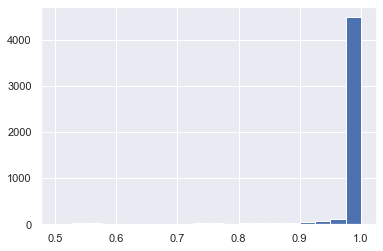

In [48]:
build_conf_hist(sentiment_points, 'mu_rds')

Iter 00, logit: -7.310684
Iter 10, logit: -6.342921
Iter 20, logit: -6.319032
Iter 30, logit: -6.307369
Iter 40, logit: -6.303087
Iter 50, logit: -6.303465
Iter 60, logit: -6.303721
Iter 70, logit: -6.303388
Iter 80, logit: -6.303361
Iter 90, logit: -6.303411
Iter 100, logit: -6.303446
---------------
Label accuracy is 0.7485714285714286
--------------------------------------------------
Data has 125 features
Iter 00, logit: -7.231114
Iter 10, logit: -6.103836
Iter 20, logit: -6.007107
Iter 30, logit: -5.929050
Iter 40, logit: -5.857424
Iter 50, logit: -5.793060
Iter 60, logit: -5.733514
Iter 70, logit: -5.677250
Iter 80, logit: -5.623725
Iter 90, logit: -5.572688
Iter 100, logit: -5.523977
Iter 110, logit: -5.477419
Iter 120, logit: -5.432818
Iter 130, logit: -5.390082
Iter 140, logit: -5.349424
Iter 150, logit: -5.310492
Iter 160, logit: -5.273057
Iter 170, logit: -5.237717
Iter 180, logit: -5.204681
Iter 190, logit: -5.171088
(700, 125)
Classifier train accuracy is 0.764285714285714

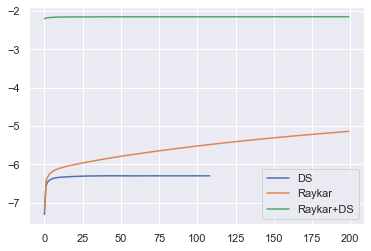

In [92]:
reload(ds), reload(r), reload(rds)
music_methods, music_points, advantages_matrix = compare_methods(music_data, max_iter=200, lr=100)

In [ ]:
# music_points[music_points.grad_r < 2]

Number of data points: 700


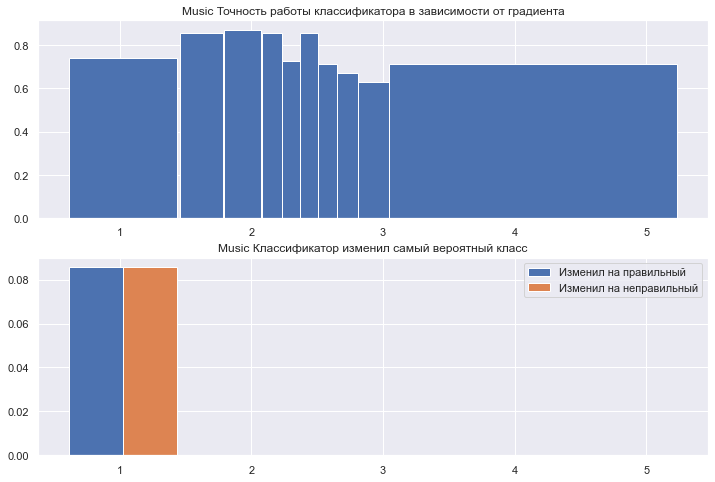

In [94]:
buckets, confidences, wrong, correct = build_grad_hist(music_data, music_methods, music_points, 'Music', 70);
condidence_music = get_confidence(buckets[0], confidences[0])

6 6


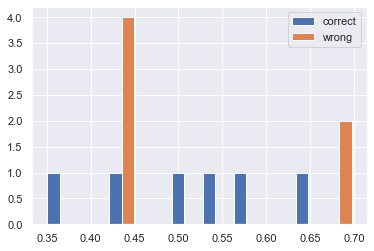

In [96]:
plot_flips(correct, wrong, 'mu_ds')

In [ ]:
reload(ds), reload(r), reload(rds)
music_methods, music_points, advantages_matrix = compare_methods(music_data, max_iter=200, lr=100, confidence_estimator=condidence_music)

In [ ]:
music_points[music_points.task.isin(advantages_matrix[1][2])]

In [ ]:
# reload(ds)
# reload(r)
# reload(rds)

# shuffle_features(ionosphere_data)

# ionosphere_methods = compare_methods(ionosphere_data, max_iter=100)

In [ ]:
# reload(ds), reload(r), reload(rds)

# shuffle_features(sentiment_data)

# sentiment_methods = compare_methods(sentiment_data, max_iter=15)
# # print_conf(sentiment_methods)

In [ ]:
# reload(ds), reload(r), reload(rds)
# shuffle_features(music_data)
# music_methods = compare_methods(music_data, max_iter=100)

Check sentiment dataset

In [ ]:
X_train, y_train = features2np(sentiment_data)

reg = LogisticRegression().fit(X_train, y_train)

X_test, y_test = sentiment_data.test()

pred = reg.predict(X_train)
print(accuracy_score(y_train, pred))

pred = reg.predict(X_test)
print(accuracy_score(y_test, pred))

In [ ]:
X_train, y_train = features2np(mushrooms_data)

reg = LogisticRegression().fit(X_train, y_train)

X_test, y_test = mushrooms_data.test()

pred = reg.predict(X_train)
print(accuracy_score(y_train, pred))

pred = reg.predict(X_test)
print(accuracy_score(y_test, pred))

In [ ]:
len(sentiment_data.gold())

In [ ]:
(y_test == 'pos').sum() / len(y_test)

In [ ]:
X_train, y_train = features2np(music_data)
# X_train[:, -1] = 1

reg = LogisticRegression(max_iter=2000).fit(X_train, y_train)

X_test, y_test = music_data.test()
# X_test[:, -1] = 1

pred = reg.predict(X_train)
print(accuracy_score(y_train, pred))

pred = reg.predict(X_test)
print(accuracy_score(y_test, pred))

In [ ]:
X_train, y_train = features2np(toloka_data)
# X_train[:, -1] = 1

reg = LogisticRegression(max_iter=2000).fit(X_train, y_train)

# X_test, y_test = music_data.test()
# X_test[:, -1] = 1

pred = reg.predict(X_train)
print(accuracy_score(y_train, pred))
len(toloka_data.gold())
reg.coef_
# X_train.shape
# X_train
# pred = reg.predict(X_test)
# print(accuracy_score(y_test, pred))lf 

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)


from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore').fit(y_train[:, None])
y_train1 = enc.transform(y_train[:, None]).toarray()
y_test1 = enc.transform(y_test[:, None]).toarray()
y_train1.shape

In [ ]:
def consistency(data, iters=100000):
    cnt = 0
    task2annotations = defaultdict(list)
    for a in data.labels():
        task2annotations[a.task].append(a)
    for _ in range(iters):
        a = random.choice(data.labels())
        if len(task2annotations[a.task]) == 1:
#             cnt+=1
            continue
        b = random.choice(task2annotations[a.task])
        while a == b:
            b = random.choice(task2annotations[a.task])
        if a.value == b.value:
            cnt += 1
    return cnt / iters
print(f"Ionosphere consistency is {consistency(ionosphere_data)}")
print(f"Sentiment consistency is {consistency(sentiment_data)}")
print(f"Music consistency is {consistency(music_data)}")

In [ ]:
def run_classifier(dataset, n_classes=2, iters=100, lr=0.1):
    ids, features, gold = data.group_data(dataset.features(), dataset.gold())
    c = cls.Classifier(n_features=features.shape[1], n_classes=n_classes, lr=lr)

    labels = np.unique(gold)

    X = features
    Xs = X.T.dot(X)
    mu = np.zeros((len(features), len(labels)))
    for i, label in enumerate(labels):
        mu[gold == label, i] = 1
    for i in tqdm(range(iters)):
        c.update_w(X, Xs, mu, len(features))

    results = c.apply(features, labels)
    
    return c, results, features, gold

In [ ]:
def build_cls_grad_hist(ax, cls, features, correct, name, n_bucket=100):
    print(correct.sum() / len(correct))
    fig = plt.figure(figsize=(12, 8))
    print(f'Number of data points: {len(correct)}')
    
    scores = cls.get_scores(features)

    result = []

    for f, s, c in zip(features, scores, correct):
        if type(s) is float:
            grad = np.linalg.norm(min(1 - s, s) * f)
        else:
            grad = np.linalg.norm((1 - np.max(s)) * f)
        if c:
            result.append([grad, True])
        else:
            result.append([grad, False])

    result = np.array(sorted(result))
    print(result[-1])
    n = int(np.ceil(len(correct) / n_bucket))
    xs = []
    widths = []
    heights = []
    for i in range(n):
        cur_points = result[n_bucket * i: min(n_bucket * (i + 1), len(correct))]
        xs.append((cur_points[0, 0] + cur_points[-1, 0]) * 0.5)
        widths.append((cur_points[-1, 0] - cur_points[0, 0]))
        heights.append(cur_points[:, 1].sum() / len(cur_points))
        if widths[-1] == 0:
            print(cur_points)

    ax.bar(xs, height=heights, width=widths)
    ax.set_xlabel('Gradient')
    ax.set_ylabel('Accuracy')
    ax.set_title(name)
    print(np.array(heights).mean())
    print(widths)


In [ ]:
# c_sentiment, results_sentiment, features_sentiment, gold_sentiment = run_classifier(sentiment_data, iters=15)
# c_mushrooms, results_mushroomes, features_mushrooms, gold_mushrooms = run_classifier(mushrooms_data, iters=50)
c_music, results_music, features_music, gold_music = run_classifier(music_data, n_classes=10, iters=50, lr=100)
c_toloka, results_toloka, features_toloka, gold_toloka = run_classifier(toloka_data, n_classes=5, iters=50, lr=100)

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.subplots(nrows=4, ncols=1)


# build_cls_grad_hist(ax[0], c_mushrooms, features_mushrooms, results_mushroomes == gold_mushrooms, "Mushrooms", 400)
# build_cls_grad_hist(ax[1], c_sentiment, features_sentiment, results_sentiment == gold_sentiment, "Sentiment", 400)
build_cls_grad_hist(ax[2], c_music, features_music, results_music == gold_music, "Music", 70)
build_cls_grad_hist(ax[3], c_toloka, features_toloka, results_toloka == gold_toloka, "Toloka", 70)

In [ ]:
scores = c.get_scores(features)
plt.hist(scores)

In [ ]:
(results_music == gold_music).mean()

In [ ]:
results_music

In [ ]:
from sklearn.datasets import load_iris

In [ ]:
X, y = load_iris(return_X_y=True)
features = np.ones((X.shape[0], X.shape[1] + 1))
features[:, :-1] = X
X = features

In [ ]:
reload_all()

c = cls.Classifier(n_features=X.shape[1], n_classes=3, lr=1000)

labels = np.unique(y)

Xs = X.T.dot(X)
mu = np.zeros((len(X), len(labels)))
for i, label in enumerate(labels):
    mu[y == label, i] = 1
for i in tqdm(range(60)):
    c.update_w(X, Xs, mu, len(X))

results = c.apply(X, labels)
(results == y).mean()

In [ ]:
logreg = LogisticRegression().fit(X, y)

In [ ]:
(404517869995362 + 35) % 37

In [ ]:
404517869991331 % 37

In [ ]:
np.random.randn(3, 3) * 0.1